### Import libraries

In [7]:
# Core
import os, re, math, textwrap, unicodedata
from collections import Counter

# Data & viz
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from textblob import TextBlob

# Ensure NLTK data is present (safe to rerun)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')  # POS tagger used under the hood
sns.set()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moein\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moein\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moein\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Load the twentieth-century text

In [5]:
# Adjust paths if notebook sits elsewhere
TEXT_PATH = os.path.join("..", "data", "raw", "key_events_20th_century_raw.txt")

if not os.path.exists(TEXT_PATH):
    raise FileNotFoundError(f"Could not find: {TEXT_PATH}. Put your scraped TXT there.")

with open(TEXT_PATH, "r", encoding="utf-8", errors="ignore") as f:
    raw_text = f.read()

# Quick peek
print(raw_text[:800])

SOURCE: https://en.wikipedia.org/wiki/Key_events_of_the_20th_century
DOWNLOADED: 2025-08-18 10:45:33 UTC
LICENSE: Wikipedia content is under CC BY-SA 4.0.

## Historic events in the 20th century

## World at the beginning of the century

## "The war to end all wars": World War I (1914–1918)

## Spanish flu

## Russian Revolution and communism

## Between the wars

## Economic depression

## The rise of dictatorship

## Global war: World War II (1939–1945)

## The war in Europe

## Blitzkrieg

## Operation Barbarossa

## Turning tides

## Operation Overlord

## Final days

## The war in the Pacific

## Japanese Expansion

## Allied offensive

## Final days

## The Holocaust

## The Nuclear Age begins

## The post-war world

## The end of empires: decolonization

## The Cold War (1947–1991)



### Tokenize words & plot the top 10 most common words

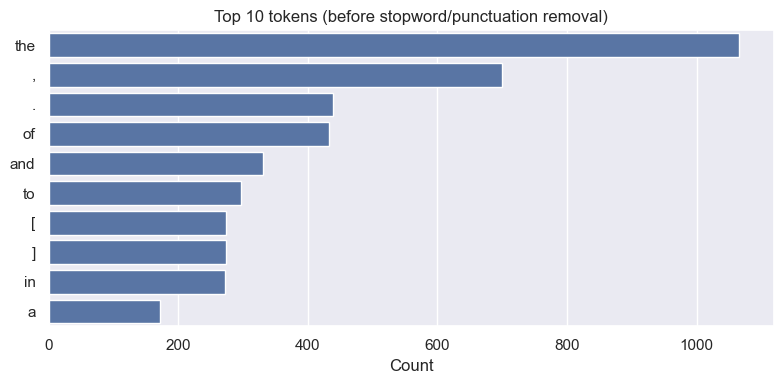

In [10]:
# Basic normalization: keep original for phrase-matching later; derive a lowercased copy for token stats
text_for_tokens = raw_text.lower()

# Word tokens
tokens = word_tokenize(text_for_tokens)

# Frequency (raw)
freq = Counter(tokens)
top10 = pd.DataFrame(freq.most_common(10), columns=["token", "count"])

plt.figure(figsize=(8,4))
sns.barplot(data=top10, x="count", y="token")
plt.title("Top 10 tokens (before stopword/punctuation removal)")
plt.xlabel("Count"); plt.ylabel("")
plt.tight_layout()
plt.show()

### Remove stop words & punctuation, re-plot

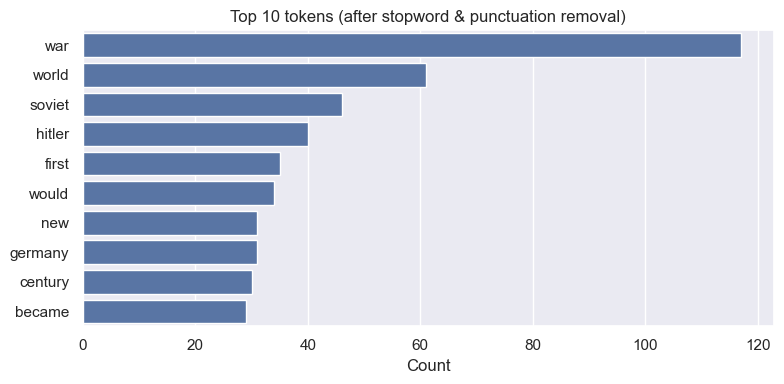

In [11]:
# Build stopword set + simple punctuation filter
sw = set(stopwords.words("english"))

def is_word(tok: str) -> bool:
    # Keep alphabetic tokens only (drop punctuation/numbers)
    return tok.isalpha()

clean_tokens = [t for t in tokens if is_word(t) and t not in sw]

freq_clean = Counter(clean_tokens)
top10_clean = pd.DataFrame(freq_clean.most_common(10), columns=["token", "count"])

plt.figure(figsize=(8,4))
sns.barplot(data=top10_clean, x="count", y="token")
plt.title("Top 10 tokens (after stopword & punctuation removal)")
plt.xlabel("Count"); plt.ylabel("")
plt.tight_layout()
plt.show()

What changed? After removing stop words/punctuation, generic English words vanished (e.g., “the”, “and”), surfacing event-specific terms. This gives a more meaningful picture of salient content that actually signals topics and entities.

### Create a tags list with TextBlob

In [14]:
# Use a moderately cleaned string for POS tagging
text_for_pos = " ".join(clean_tokens)
blob = TextBlob(text_for_pos)

# Each tag is (word, tag)
tags_list = blob.tags
len(tags_list), tags_list[:12]

(6005,
 [('source', 'NN'),
  ('https', 'NN'),
  ('downloaded', 'VBD'),
  ('utc', 'JJ'),
  ('license', 'NN'),
  ('wikipedia', 'NN'),
  ('content', 'NN'),
  ('cc', 'NN'),
  ('historic', 'JJ'),
  ('events', 'NNS'),
  ('century', 'NN'),
  ('world', 'NN')])

### Top 10 POS tags in the article

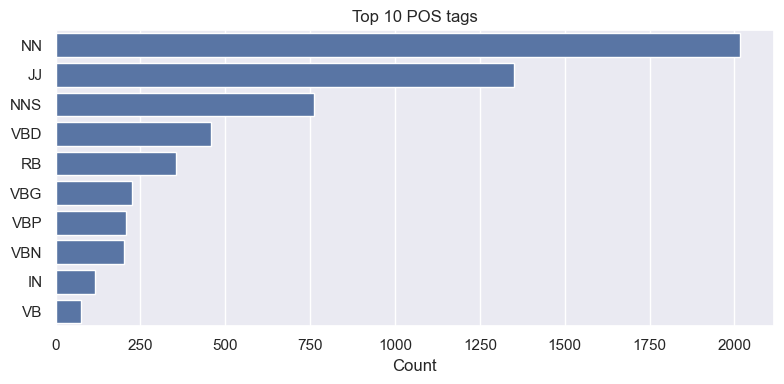

,POS,count
0,NN,2016
2,JJ,1352
3,NNS,760
1,VBD,458
8,RB,355
4,VBG,224
6,VBP,207
10,VBN,202
5,IN,116
13,VB,74


In [15]:
# Count POS tags
pos_counts = Counter(tag for _, tag in tags_list)
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "count"]).sort_values("count", ascending=False)

top10_pos = pos_df.head(10)

plt.figure(figsize=(8,4))
sns.barplot(data=top10_pos, x="count", y="POS")
plt.title("Top 10 POS tags")
plt.xlabel("Count"); plt.ylabel("")
plt.tight_layout()
plt.show()

top10_pos

### Three bar plots: top 15 nouns, verbs, adjectives

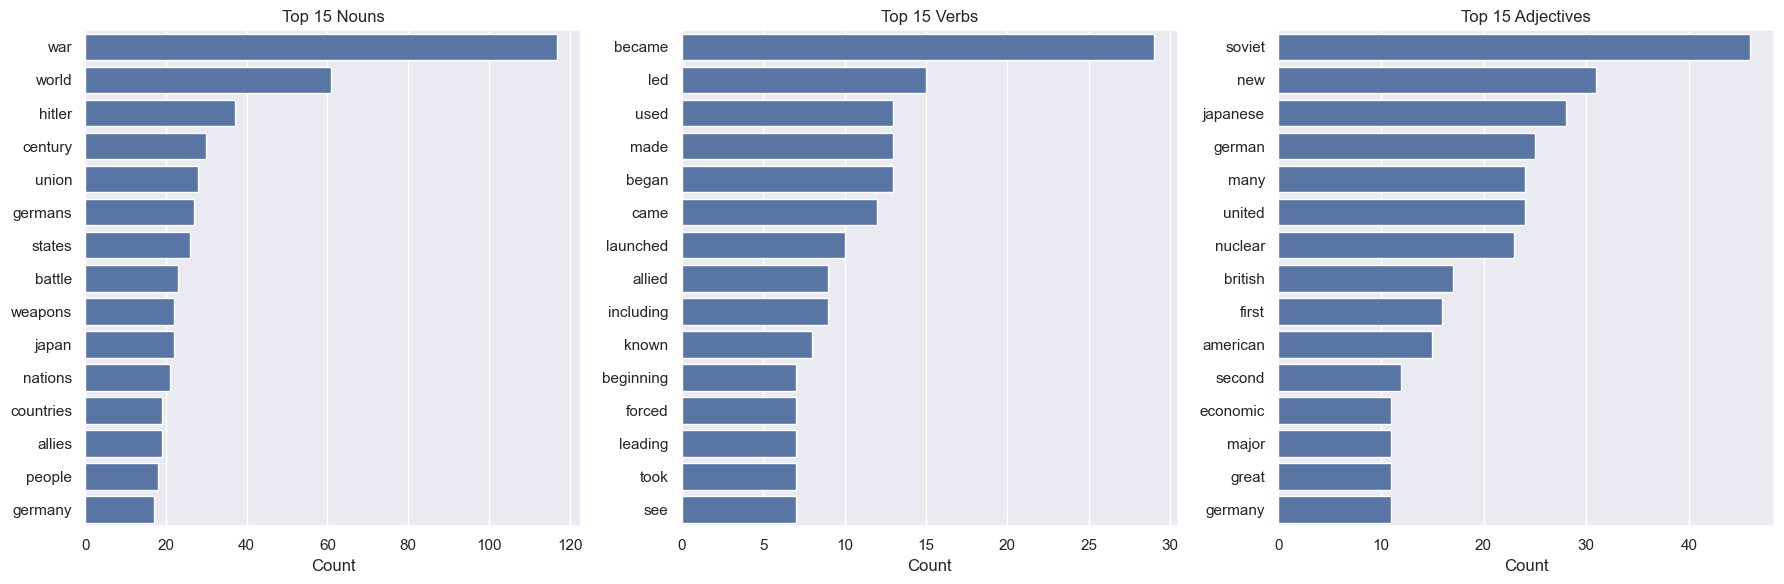

In [16]:
# Tag families
NOUN = {"NN","NNS","NNP","NNPS"}
VERB = {"VB","VBD","VBG","VBN","VBP","VBZ"}
ADJ  = {"JJ","JJR","JJS"}

# Filter tokens by POS family
def top_k_by_pos(pairs, pos_set, k=15):
    words = [w for (w, t) in pairs if t in pos_set and w.isalpha()]
    return pd.DataFrame(Counter(words).most_common(k), columns=["word","count"])

top_nouns = top_k_by_pos(tags_list, NOUN, 15)
top_verbs = top_k_by_pos(tags_list, VERB, 15)
top_adjs  = top_k_by_pos(tags_list, ADJ,  15)

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=False)
sns.barplot(ax=axes[0], data=top_nouns, x="count", y="word");  axes[0].set_title("Top 15 Nouns")
sns.barplot(ax=axes[1], data=top_verbs, x="count", y="word");  axes[1].set_title("Top 15 Verbs")
sns.barplot(ax=axes[2], data=top_adjs,  x="count", y="word");  axes[2].set_title("Top 15 Adjectives")
for ax in axes: ax.set_xlabel("Count"); ax.set_ylabel("")
plt.tight_layout(); plt.show()

The frequency distributions highlight key themes of the twentieth-century narrative:

- Nouns are dominated by war, world, and Hitler, reflecting how global conflict—especially the two World Wars—defined much of the century. Other recurring nouns such as states, weapons, battle, and union further emphasize the centrality of military and geopolitical struggles.

- Verbs such as became, led, used, and made indicate actions tied to leadership, technological development, and change. The verbs reflect not only warfare (launched, allied, forced) but also broader historical transitions (including, beginning).

- Adjectives are dominated by terms like soviet, new, japanese, and german, showing the prominence of national and ideological identities. Words like nuclear, economic, and major underscore the rise of technological power and structural transformations across the century.

### Countries lookup → mentions per country

In [17]:
COUNTRIES_PATH = os.path.join("..", "data", "reference", "countries_list_20th_century_1.5.csv")
countries_df = pd.read_csv(COUNTRIES_PATH)
countries_df.head()  # Expect a column with country names (e.g., 'country' or similar)

,Unnamed: 0,country_name
0,1,Afghanistan
1,2,Albania
2,3,Algeria
3,4,Andorra
4,5,Angola


In [18]:
# Try to locate the column that holds country names
if "country" not in [c.lower() for c in countries_df.columns]:
    # Heuristic: take the first column and rename
    countries_df.columns = ["country"] + list(countries_df.columns[1:])
else:
    # Make sure the column is literally named 'country'
    for c in countries_df.columns:
        if c.lower()=="country": 
            countries_df = countries_df.rename(columns={c:"country"})
            break

countries_df["country"] = countries_df["country"].astype(str).str.strip()
countries_df.dropna(subset=["country"], inplace=True)

In [19]:
# Use the original (un-lowercased) text to preserve capitalization; normalize whitespace
text_for_match = re.sub(r"\s+", " ", raw_text)

def count_mentions(haystack: str, needle: str) -> int:
    # Word-boundary match, safe-escaped
    pattern = r"\b" + re.escape(needle) + r"\b"
    return len(re.findall(pattern, haystack, flags=re.IGNORECASE))

countries_df["mentions"] = countries_df["country"].apply(lambda c: count_mentions(text_for_match, c))
countries_df.sort_values("mentions", ascending=False).head(12)

,country,country_name,mentions
1,2,Albania,10
0,1,Afghanistan,7
5,6,Antigua and Barbuda,7
6,7,Argentina,7
9,10,Austria,6
19,20,Bhutan,6
8,9,Australia,5
28,29,Cambodia,4
7,8,Armenia,4
25,26,Bulgaria,4


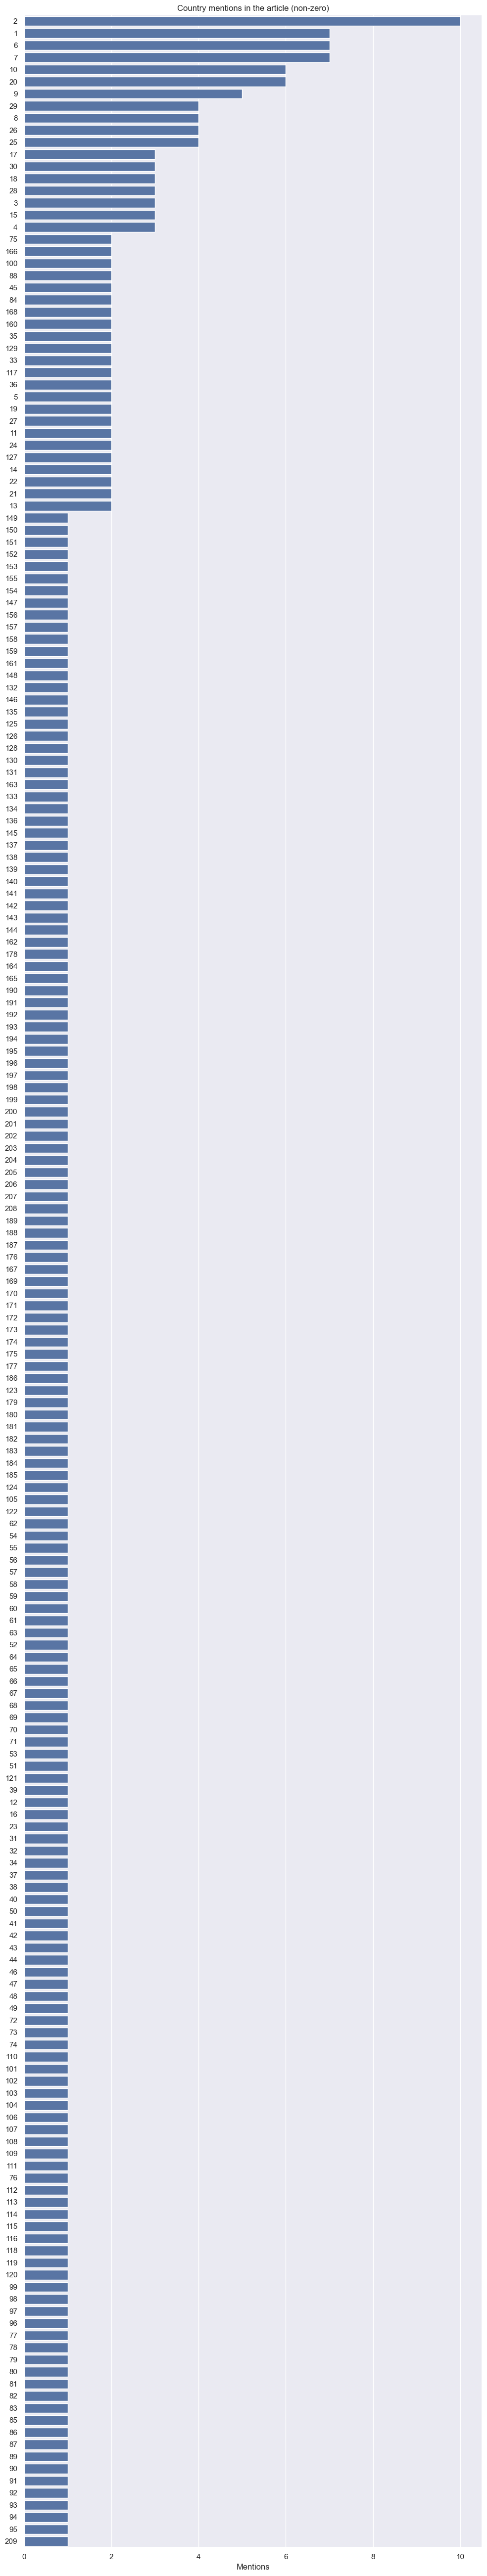

In [21]:
# Plot frequency of mentions (bar of all with >0)

nonzero = countries_df[countries_df["mentions"] > 0].sort_values("mentions", ascending=False)
plt.figure(figsize=(10, max(4, 0.25 * len(nonzero))))  # dynamic height
sns.barplot(data=nonzero, x="mentions", y="country")
plt.title("Country mentions in the article (non-zero)")
plt.xlabel("Mentions"); plt.ylabel("")
plt.tight_layout(); plt.show()

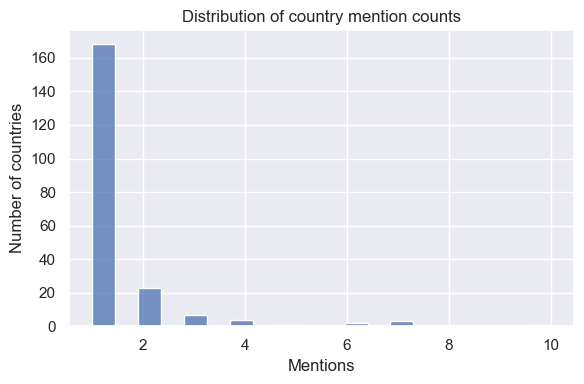

In [23]:
# Distribution overview (histogram)

plt.figure(figsize=(6,4))
sns.histplot(countries_df["mentions"], bins=20)
plt.title("Distribution of country mention counts")
plt.xlabel("Mentions"); plt.ylabel("Number of countries")
plt.tight_layout(); plt.show()

The analysis of country mentions reveals that while a large number of countries are referenced, most of them are mentioned only once or twice. The distribution is therefore highly skewed, with a few countries dominating the text.

The first plot shows the distribution of mention counts:

- The vast majority of countries appear only once.

- Very few countries are mentioned more than five times.

The second plot highlights the specific countries and their frequencies. Although many countries are included in the lookup list, only a small subset is directly tied to the main historical narratives of the twentieth century.

This suggests that the text is strongly focused on a limited set of nations—likely those central to global conflicts and political transformations—while the rest are mentioned in passing.